In [1]:
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
from darksky import forecast
import config
import numpy as np
import xgboost as xgb
import world_bank_data as wb
from pandas.plotting import lag_plot
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
key = config.api__key
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
np.random.seed(0)

## Load the dataset and take a quick look at it. 

In [2]:
df = pd.read_csv('MY.38362002.csv')

In [3]:
df.info()
df.drop(['ConditionName','ConditionSNOMED','PathogenName', 'PathogenTaxonID','CountryName','CountryISO', 'Admin1ISO','Admin2Name', 'CityName','PlaceOfAcquisition','DiagnosisCertainty','SourceName'], axis = 1, inplace = True)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2034 entries, 0 to 2033
Data columns (total 20 columns):
ConditionName                  2034 non-null object
ConditionSNOMED                2034 non-null int64
PathogenName                   2034 non-null object
PathogenTaxonID                2034 non-null int64
Fatalities                     2034 non-null int64
CountryName                    2034 non-null object
CountryISO                     2034 non-null object
Admin1Name                     1944 non-null object
Admin1ISO                      1944 non-null object
Admin2Name                     0 non-null float64
CityName                       0 non-null float64
PeriodStartDate                2034 non-null object
PeriodEndDate                  2034 non-null object
PartOfCumulativeCountSeries    2034 non-null int64
AgeRange                       2034 non-null object
Subpopulation                  2034 non-null object
PlaceOfAcquisition             0 non-null float64
DiagnosisCertainty 

## The following is a description of each ot hte features accord to https://www.tycho.pitt.edu/dataformat/ProjectTychoPreCompiledDataFormat.pdf

<img src="1.png">
<img src="2.png">
<img src="3.png">

I immediatley dropped any features with 0 observations: DiagnosisCertainty, PlaceOfAcquistion, CityName, Admin2Name
I also dropped features that are reduntant. This dataset presents information on Dengue Fever in Malaysia, I'd say it's safe to drop ConditionName, ConditionSNOMED, PathogenName, PathogenName, PathogenTaxonID, and CountryName. Admin1ISO was also dropped as it is just reporting the ISO 3166 code for the Admin1 feature

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2034 entries, 0 to 2033
Data columns (total 8 columns):
Fatalities                     2034 non-null int64
Admin1Name                     1944 non-null object
PeriodStartDate                2034 non-null object
PeriodEndDate                  2034 non-null object
PartOfCumulativeCountSeries    2034 non-null int64
AgeRange                       2034 non-null object
Subpopulation                  2034 non-null object
CountValue                     2034 non-null int64
dtypes: int64(3), object(5)
memory usage: 127.2+ KB


### Admin 1 name is the name of the city, we're missing about 90 city names which represents only about 5% of the whole set, I feel comfortable dropping null values. s

In [5]:
df = df.dropna()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1944 entries, 0 to 1943
Data columns (total 8 columns):
Fatalities                     1944 non-null int64
Admin1Name                     1944 non-null object
PeriodStartDate                1944 non-null object
PeriodEndDate                  1944 non-null object
PartOfCumulativeCountSeries    1944 non-null int64
AgeRange                       1944 non-null object
Subpopulation                  1944 non-null object
CountValue                     1944 non-null int64
dtypes: int64(3), object(5)
memory usage: 136.7+ KB


#### Let's observe what we're left with starting with fatalities

In [7]:
df.Fatalities.value_counts()

0    1944
Name: Fatalities, dtype: int64

### All values are 0, drop this column

In [8]:
df.drop('Fatalities', inplace = True, axis = 1)

### Next check subpopulation, all values are "None Specified", drop this column

In [9]:
df.Subpopulation.unique()

array(['None specified'], dtype=object)

In [10]:
df.drop('Subpopulation', inplace = True, axis = 1)

### Same with Part of Cumulative Count and age range

In [11]:
df.PartOfCumulativeCountSeries.unique(), df.AgeRange.unique()

(array([0]), array(['0-130'], dtype=object))

In [12]:
df.drop(['PartOfCumulativeCountSeries', 'AgeRange'], axis = 1, inplace = True)

### Observe "admin1name"

In [13]:
df.Admin1Name.value_counts()

NEGERI SEMBILAN    216
JOHOR              216
PERLIS             216
PAHANG             216
PULAU PINANG       204
KELANTAN           204
SELANGOR           192
PERAK              192
SARAWAK            144
SABAH              144
Name: Admin1Name, dtype: int64

In [14]:
sum(df.Admin1Name.value_counts().values)

1944

In [15]:
df.rename(columns={'Admin1Name':'City'}, inplace = True) ##rename as City

### Change date columns to type datetime

In [16]:
df.head()

City PeriodStartDate PeriodEndDate  CountValue
0  JOHOR      1993-01-01    1993-01-31          41
1  JOHOR      1993-02-01    1993-02-28          52
2  JOHOR      1993-03-01    1993-03-31          35
3  JOHOR      1993-04-01    1993-04-30          45
4  JOHOR      1993-05-01    1993-05-31          55

In [17]:
df["PeriodStartDate"]= pd.to_datetime(df["PeriodStartDate"]) 
df["PeriodEndDate"]= pd.to_datetime(df["PeriodEndDate"]) 

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1944 entries, 0 to 1943
Data columns (total 4 columns):
City               1944 non-null object
PeriodStartDate    1944 non-null datetime64[ns]
PeriodEndDate      1944 non-null datetime64[ns]
CountValue         1944 non-null int64
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 75.9+ KB


### It looks like each observation is made in the span of a month. Let's confirm that though by plotting start date vs. end date

In [19]:
dayStart = df.PeriodStartDate.dt.day
dayEnd = df.PeriodEndDate.dt.day

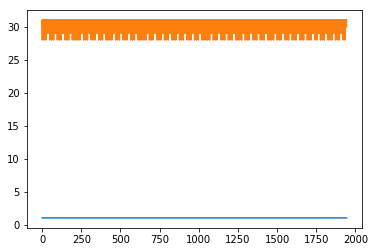

In [20]:
plt.plot(dayStart)
plt.plot(dayEnd)
plt.show() 
###yup, we're looking at observations made in a month

In [21]:
month = df.PeriodStartDate.dt.month
year = df.PeriodStartDate.dt.year
df.drop(['PeriodEndDate','PeriodStartDate'], axis = 1, inplace = True)
df['month'] = month
df['year'] = year

##let's consolidate to years and months

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1944 entries, 0 to 1943
Data columns (total 4 columns):
City          1944 non-null object
CountValue    1944 non-null int64
month         1944 non-null int64
year          1944 non-null int64
dtypes: int64(3), object(1)
memory usage: 75.9+ KB


### Dengue is a mosquito borne disease. Mosquitos thrive in certain weather conditions. I'd like to see if weather has any effect on reported cases of Dengue. I used darksky to collect all available high temperature, humidity, windspeed, and cloud coverage data for the cities represented in the dataset

In [23]:
df.City.unique()

array(['JOHOR', 'KELANTAN', 'NEGERI SEMBILAN', 'PAHANG', 'PERAK',
       'PERLIS', 'PULAU PINANG', 'SABAH', 'SARAWAK', 'SELANGOR'],
      dtype=object)

In [24]:
Johor = key, 1.4854, 103.7618
Kelantan = key, 6.1253, 102.2376
NS = key, 2.7258, 101.9424
Pahang = key, 3.8126, 103.3256
Perak = key, 4.5921, 101.0901
Perlis = key, 6.4449, 100.2048
Pulau = key, 5.4164, 100.3327
Sabah = key, 5.9788, 116.0753
Sarawak = key, 1.5533, 110.3592
Selangor = key, 3.0738, 101.5183


In [25]:
fore = forecast(*Johor, time = dt(1993,1,1).isoformat())

In [26]:
fore['daily']

{'data': [{'time': 725817600,
   'summary': 'Humid throughout the day.',
   'icon': 'partly-cloudy-day',
   'sunriseTime': 725843313,
   'sunsetTime': 725886645,
   'moonPhase': 0.26,
   'precipType': 'rain',
   'temperatureHigh': 85.7,
   'temperatureHighTime': 725871600,
   'temperatureLow': 74.89,
   'temperatureLowTime': 725918400,
   'apparentTemperatureHigh': 93.04,
   'apparentTemperatureHighTime': 725871600,
   'apparentTemperatureLow': 76.55,
   'apparentTemperatureLowTime': 725918400,
   'dewPoint': 74.14,
   'humidity': 0.87,
   'pressure': 1013.77,
   'windSpeed': 6.91,
   'windBearing': 25,
   'cloudCover': 0.83,
   'uvIndex': 5,
   'uvIndexTime': 725868000,
   'temperatureMin': 74.89,
   'temperatureMinTime': 725828400,
   'temperatureMax': 85.7,
   'temperatureMaxTime': 725871600,
   'apparentTemperatureMin': 76.55,
   'apparentTemperatureMinTime': 725832000,
   'apparentTemperatureMax': 93.04,
   'apparentTemperatureMaxTime': 725871600}]}

In [27]:
def getWeatherData (df, key, weather):
    '''use an api call to extract weather information for a specific city during a specific
    month and year, append to a list. NAN if observations for input criteria unavailable'''
    w = []
    for i in df.index.tolist():
        fore = forecast(*key, time = dt(df['year'][i],df['month'][i],1).isoformat())
        try:
            w.append(fore['daily']['data'][0][weather])
        except KeyError:
            w.append(np.nan)
    return w
    

In [28]:
%%time
J = df[df.City == 'JOHOR']
weatherConditions = ['cloudCover', 'windSpeed', 'humidity', 'temperatureMax']
for i in weatherConditions:
    wC = getWeatherData(J, Johor, i)
    J[i] = wC

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


CPU times: user 26.1 s, sys: 1.7 s, total: 27.8 s
Wall time: 4min 36s


In [29]:
%%time
Kel = df[df.City == 'KELANTAN']
weatherConditions = ['cloudCover', 'windSpeed', 'humidity', 'temperatureMax']
for i in weatherConditions:
    wC = getWeatherData(Kel,Kelantan,i)
    Kel[i] = wC

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


CPU times: user 24.6 s, sys: 2.02 s, total: 26.6 s
Wall time: 4min 21s


In [30]:
%%time
N = df[df.City == 'NEGERI SEMBILAN']

weatherConditions = ['cloudCover', 'windSpeed', 'humidity', 'temperatureMax']
for i in weatherConditions:
    wC = getWeatherData(N,NS,i)
    N[i] = wC

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CPU times: user 25.3 s, sys: 1.58 s, total: 26.9 s
Wall time: 4min 19s


In [31]:
%%time
Pah = df[df.City == 'PAHANG']

weatherConditions = ['cloudCover', 'windSpeed', 'humidity', 'temperatureMax']
for i in weatherConditions:
    wC = getWeatherData(Pah,Pahang,i)
    Pah[i] = wC

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CPU times: user 25.9 s, sys: 1.79 s, total: 27.7 s
Wall time: 4min 17s


In [32]:
%%time
Per = df[df.City == 'PERAK']

weatherConditions = ['cloudCover', 'windSpeed', 'humidity', 'temperatureMax']
for i in weatherConditions:
    wC = getWeatherData(Per,Perak,i)
    Per[i] = wC

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CPU times: user 22.4 s, sys: 1.84 s, total: 24.2 s
Wall time: 3min 49s


In [33]:
%%time
Perl = df[df.City == 'PERLIS']

weatherConditions = ['cloudCover', 'windSpeed', 'humidity', 'temperatureMax']
for i in weatherConditions:
    wC = getWeatherData(Perl,Perlis,i)
    Perl[i] = wC

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CPU times: user 26.2 s, sys: 2.04 s, total: 28.2 s
Wall time: 4min 20s


In [34]:
%%time
Pul = df[df.City == 'PULAU PINANG']

weatherConditions = ['cloudCover', 'windSpeed', 'humidity', 'temperatureMax']
for i in weatherConditions:
    wC = getWeatherData(Pul,Pulau,i)
    Pul[i] = wC

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CPU times: user 24.3 s, sys: 1.59 s, total: 25.9 s
Wall time: 3min 53s


In [35]:
%%time
Sab = df[df.City == 'SABAH']

weatherConditions = ['cloudCover', 'windSpeed', 'humidity', 'temperatureMax']
for i in weatherConditions:
    wC = getWeatherData(Sab,Sabah,i)
    Sab[i] = wC

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CPU times: user 17.3 s, sys: 1.13 s, total: 18.4 s
Wall time: 2min 16s


In [36]:
%%time
Sar = df[df.City == 'SARAWAK']

weatherConditions = ['cloudCover', 'windSpeed', 'humidity', 'temperatureMax']
for i in weatherConditions:
    wC = getWeatherData(Sar,Sarawak,i)
    Sar[i] = wC

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CPU times: user 17.1 s, sys: 992 ms, total: 18.1 s
Wall time: 2min 35s


In [37]:
%%time
Selan = df[df.City == 'SELANGOR']

weatherConditions = ['cloudCover', 'windSpeed', 'humidity', 'temperatureMax']
for i in weatherConditions:
    wC = getWeatherData(Selan,Selangor,i)
    Selan[i] = wC


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CPU times: user 22.9 s, sys: 1.67 s, total: 24.6 s
Wall time: 3min 50s


In [38]:
mdf = pd.concat([J,Kel,N,Pah,Per,Perl,Pul,Sab,Sar,Selan], axis = 0)

In [39]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1944 entries, 0 to 1943
Data columns (total 8 columns):
City              1944 non-null object
CountValue        1944 non-null int64
month             1944 non-null int64
year              1944 non-null int64
cloudCover        1316 non-null float64
windSpeed         1348 non-null float64
humidity          1336 non-null float64
temperatureMax    1344 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 136.7+ KB


In [40]:
mdf.head()

City  CountValue  month  year  cloudCover  windSpeed  humidity  \
0  JOHOR          41      1  1993        0.83       6.91      0.87   
1  JOHOR          52      2  1993         NaN       8.87      0.79   
2  JOHOR          35      3  1993         NaN       3.96      0.91   
3  JOHOR          45      4  1993         NaN       3.42      0.84   
4  JOHOR          55      5  1993        0.88       2.99      0.86   

   temperatureMax  
0           85.70  
1           85.86  
2           83.35  
3           87.52  
4           89.31

### GDP is a loose interpretation of how well a country is doing financially. As it's hard to find GDP base on city I will include GDP for every year from 1993-2010. Same with population. 

In [41]:
wb.get_topics()

value  \
id                                    
1   Agriculture & Rural Development   
2                 Aid Effectiveness   
3                  Economy & Growth   
4                         Education   
5                   Energy & Mining   
6                       Environment   
7                  Financial Sector   
8                            Health   
9                    Infrastructure   
10        Social Protection & Labor   
11                          Poverty   
12                   Private Sector   
13                    Public Sector   
14             Science & Technology   
15               Social Development   
16                Urban Development   
17                           Gender   
18      Millenium development goals   
19                   Climate Change   
20                    External Debt   
21                            Trade   

                                           sourceNote  
id                                                     
1   For the 70 percent of the world's poor who liv...  
2   Aid effectiveness is the impact that aid has i...  
3   Economic growth is central to economic develop...  
4   Education is one of the most powerful instrume...  
5   The world economy needs ever-increasing amount...  
6   Natural and man-made environmental resources –...  
7   An economy's financial markets are critical to...  
8   Improving health is central to the Millennium ...  
9   Infrastructure helps determine the success of ...  
10  The supply of labor available in an economy in...  
11  For countries with an active poverty monitorin...  
12  Private markets drive economic growth, tapping...  
13  Effective governments improve people's standar...  
14  Technological innovation, often fueled by gove...  
15  Data here cover child labor, gender issues, re...  
16  Cities can be tremendously efficient. It is ea...  
17  Gender equality is a core development objectiv...  
18                                                     
19  Climate change is expected to hit developing c...  
20  Debt statistics provide a detailed picture of ...  
21  Trade is a key means to fight poverty and achi...

In [42]:
indicators = {'NY.GDP.PCAP.CD'}

In [43]:
print(wb.get_series('NY.GDP.PCAP.CD', date = '1993', country='MYS'))
print(wb.get_series('NY.GDP.PCAP.CD', date = '1994', country='MYS'))
print(wb.get_series('NY.GDP.PCAP.CD', date = '1995', country='MYS'))
print(wb.get_series('NY.GDP.PCAP.CD', date = '1996', country='MYS'))
print(wb.get_series('NY.GDP.PCAP.CD', date = '1997', country='MYS'))
print(wb.get_series('NY.GDP.PCAP.CD', date = '1998', country='MYS'))
print(wb.get_series('NY.GDP.PCAP.CD', date = '1999', country='MYS'))
print(wb.get_series('NY.GDP.PCAP.CD', date = '2000', country='MYS'))
print(wb.get_series('NY.GDP.PCAP.CD', date = '2001', country='MYS'))
print(wb.get_series('NY.GDP.PCAP.CD', date = '2002', country='MYS'))
print(wb.get_series('NY.GDP.PCAP.CD', date = '2003', country='MYS'))
print(wb.get_series('NY.GDP.PCAP.CD', date = '2004', country='MYS'))
print(wb.get_series('NY.GDP.PCAP.CD', date = '2005', country='MYS'))
print(wb.get_series('NY.GDP.PCAP.CD', date = '2006', country='MYS'))
print(wb.get_series('NY.GDP.PCAP.CD', date = '2007', country='MYS'))
print(wb.get_series('NY.GDP.PCAP.CD', date = '2008', country='MYS'))
print(wb.get_series('NY.GDP.PCAP.CD', date = '2009', country='MYS'))
print(wb.get_series('NY.GDP.PCAP.CD', date = '2010', country='MYS'))

Country   Series                        Year
Malaysia  GDP per capita (current US$)  1993    3433.143378
Name: NY.GDP.PCAP.CD, dtype: float64
Country   Series                        Year
Malaysia  GDP per capita (current US$)  1994    3728.0929
Name: NY.GDP.PCAP.CD, dtype: float64
Country   Series                        Year
Malaysia  GDP per capita (current US$)  1995    4329.687902
Name: NY.GDP.PCAP.CD, dtype: float64
Country   Series                        Year
Malaysia  GDP per capita (current US$)  1996    4798.594228
Name: NY.GDP.PCAP.CD, dtype: float64
Country   Series                        Year
Malaysia  GDP per capita (current US$)  1997    4637.865016
Name: NY.GDP.PCAP.CD, dtype: float64
Country   Series                        Year
Malaysia  GDP per capita (current US$)  1998    3263.345371
Name: NY.GDP.PCAP.CD, dtype: float64
Country   Series                        Year
Malaysia  GDP per capita (current US$)  1999    3492.69258
Name: NY.GDP.PCAP.CD, dtype: float64
Country  

In [44]:
gdp = [0] * 1944
mdf['GDP'] = gdp

In [45]:
mdf

City  CountValue  month  year  cloudCover  windSpeed  humidity  \
0        JOHOR          41      1  1993        0.83       6.91      0.87   
1        JOHOR          52      2  1993         NaN       8.87      0.79   
2        JOHOR          35      3  1993         NaN       3.96      0.91   
3        JOHOR          45      4  1993         NaN       3.42      0.84   
4        JOHOR          55      5  1993        0.88       2.99      0.86   
5        JOHOR          56      6  1993         NaN       2.97      0.86   
6        JOHOR          67      7  1993         NaN       3.80      0.89   
7        JOHOR          52      8  1993         NaN       6.63      0.77   
8        JOHOR          54      9  1993         NaN       6.51      0.85   
9        JOHOR          26     10  1993        0.88       7.40      0.78   
10       JOHOR          16     11  1993         NaN       3.18      0.81   
11       JOHOR          31     12  1993         NaN        NaN       NaN   
12       JOHOR          17      1  1994        0.84       4.60      0.89   
13       JOHOR          27      2  1994         NaN        NaN       NaN   
14       JOHOR           9      3  1994         NaN      10.23      0.80   
15       JOHOR          19      4  1994         NaN       5.49      0.85   
16       JOHOR          21      5  1994         NaN       5.75      0.81   
17       JOHOR          32      6  1994         NaN       3.35      0.85   
18       JOHOR          68      7  1994         NaN       5.66      0.84   
19       JOHOR          61      8  1994         NaN       7.80      0.79   
20       JOHOR          69      9  1994        0.94       6.11      0.87   
21       JOHOR          84     10  1994        0.91       4.89      0.83   
22       JOHOR          70     11  1994         NaN       1.90      0.92   
23       JOHOR          48     12  1994         NaN       4.58      0.96   
24       JOHOR          54      1  1995        0.86       6.64      0.83   
25       JOHOR          47      2  1995        0.89      12.32      0.87   
26       JOHOR          62      3  1995         NaN       4.44      0.89   
27       JOHOR          38      4  1995         NaN       1.94      0.89   
28       JOHOR          72      5  1995        0.91       1.03      0.93   
29       JOHOR         106      6  1995         NaN       2.81      0.81   
...        ...         ...    ...   ...         ...        ...       ...   
1914  SELANGOR         543      7  2008        0.80       4.10      0.75   
1915  SELANGOR         494      8  2008        0.75       5.40      0.70   
1916  SELANGOR         374      9  2008        0.78       3.18      0.84   
1917  SELANGOR         432     10  2008        0.79       5.18      0.79   
1918  SELANGOR         484     11  2008        0.75       4.43      0.78   
1919  SELANGOR         545     12  2008        0.75       2.88      0.75   
1920  SELANGOR        3425      1  2009        0.75       2.42      0.81   
1921  SELANGOR        2658      2  2009        0.78       3.28      0.84   
1922  SELANGOR        2729      3  2009        0.79       2.72      0.82   
1923  SELANGOR        2564      4  2009        0.75       3.39      0.76   
1924  SELANGOR        1889      5  2009        0.75       4.31      0.74   
1925  SELANGOR        1570      6  2009        0.75       3.68      0.75   
1926  SELANGOR        1552      7  2009        0.76       2.80      0.73   
1927  SELANGOR        1088      8  2009        0.75       3.34      0.74   
1928  SELANGOR        1113      9  2009        0.86       3.24      0.87   
1929  SELANGOR        1050     10  2009        0.75       3.55      0.77   
1930  SELANGOR        1008     11  2009        0.78       2.31      0.80   
1931  SELANGOR        1776     12  2009        0.80       2.99      0.86   
1932  SELANGOR        2221      1  2010        0.78       2.89      0.88   
1933  SELANGOR        2403      2  2010        0.75       3.09      0.79   
1934  SELANGOR        2880      3  2010        0.75       

In [46]:
def addGDP(gdp,yr,df):
    for i in list(range(len(df))):
        if df['year'][i] == yr:
            df['GDP'][i] = gdp
    return df

In [47]:
%%time
mdf = addGDP(3433.143378,1993,mdf)
mdf = addGDP(3728.0929,1994,mdf)
mdf = addGDP(4329.687902,1995,mdf)
mdf = addGDP(4798.594228,1996,mdf)
mdf = addGDP(4637.865016,1997,mdf)
mdf = addGDP(3263.345371,1998,mdf)
mdf = addGDP(3492.69258,1999,mdf)
mdf = addGDP(4043.662051,2000,mdf)
mdf = addGDP(3913.428726,2001,mdf)
mdf = addGDP(4165.715233,2002,mdf)
mdf = addGDP(4461.847687,2003,mdf)
mdf = addGDP(4952.223422,2004,mdf)
mdf = addGDP(5587.02565,2005,mdf)
mdf = addGDP(6209.114104,2006,mdf)
mdf = addGDP(7243.455987,2007,mdf)
mdf = addGDP(8474.575822,2008,mdf)
mdf = addGDP(7292.493044,2009,mdf)
mdf = addGDP(9040.566251,2010,mdf)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


CPU times: user 2min 22s, sys: 1.74 s, total: 2min 24s
Wall time: 2min 43s


In [48]:
mdf.head()
mdf.GDP.unique()


array([3433, 3728, 4329, 4798, 4637, 3263, 3492, 4043, 3913, 4165, 4461,
       4952, 5587, 6209, 7243, 8474, 7292, 9040])

In [49]:
pops = [19484898,19977500,20487607,21017613,21562793,22114654,22661298,23194257,23709119,24208391,24698819,25190652,25690611,26201961,26720370,27236006,27735040,28208035]

In [50]:
len(pops)

18

In [51]:
def addPOP(pop,yr,df):
    for i in list(range(len(df))):
        if df['year'][i] == yr:
            df['population'][i] = pop
    return mdf
  

In [52]:
population = [0] * 1944
mdf['population'] = population

In [53]:
mdf.head()

City  CountValue  month  year  cloudCover  windSpeed  humidity  \
0  JOHOR          41      1  1993        0.83       6.91      0.87   
1  JOHOR          52      2  1993         NaN       8.87      0.79   
2  JOHOR          35      3  1993         NaN       3.96      0.91   
3  JOHOR          45      4  1993         NaN       3.42      0.84   
4  JOHOR          55      5  1993        0.88       2.99      0.86   

   temperatureMax   GDP  population  
0           85.70  3433           0  
1           85.86  3433           0  
2           83.35  3433           0  
3           87.52  3433           0  
4           89.31  3433           0

In [54]:
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010]

In [55]:
%%time
for i in range(len(years)):
    mdf = addPOP(pops[i],years[i],mdf)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


CPU times: user 2min 19s, sys: 1.37 s, total: 2min 20s
Wall time: 2min 28s


In [56]:
mdf

City  CountValue  month  year  cloudCover  windSpeed  humidity  \
0        JOHOR          41      1  1993        0.83       6.91      0.87   
1        JOHOR          52      2  1993         NaN       8.87      0.79   
2        JOHOR          35      3  1993         NaN       3.96      0.91   
3        JOHOR          45      4  1993         NaN       3.42      0.84   
4        JOHOR          55      5  1993        0.88       2.99      0.86   
5        JOHOR          56      6  1993         NaN       2.97      0.86   
6        JOHOR          67      7  1993         NaN       3.80      0.89   
7        JOHOR          52      8  1993         NaN       6.63      0.77   
8        JOHOR          54      9  1993         NaN       6.51      0.85   
9        JOHOR          26     10  1993        0.88       7.40      0.78   
10       JOHOR          16     11  1993         NaN       3.18      0.81   
11       JOHOR          31     12  1993         NaN        NaN       NaN   
12       JOHOR          17      1  1994        0.84       4.60      0.89   
13       JOHOR          27      2  1994         NaN        NaN       NaN   
14       JOHOR           9      3  1994         NaN      10.23      0.80   
15       JOHOR          19      4  1994         NaN       5.49      0.85   
16       JOHOR          21      5  1994         NaN       5.75      0.81   
17       JOHOR          32      6  1994         NaN       3.35      0.85   
18       JOHOR          68      7  1994         NaN       5.66      0.84   
19       JOHOR          61      8  1994         NaN       7.80      0.79   
20       JOHOR          69      9  1994        0.94       6.11      0.87   
21       JOHOR          84     10  1994        0.91       4.89      0.83   
22       JOHOR          70     11  1994         NaN       1.90      0.92   
23       JOHOR          48     12  1994         NaN       4.58      0.96   
24       JOHOR          54      1  1995        0.86       6.64      0.83   
25       JOHOR          47      2  1995        0.89      12.32      0.87   
26       JOHOR          62      3  1995         NaN       4.44      0.89   
27       JOHOR          38      4  1995         NaN       1.94      0.89   
28       JOHOR          72      5  1995        0.91       1.03      0.93   
29       JOHOR         106      6  1995         NaN       2.81      0.81   
...        ...         ...    ...   ...         ...        ...       ...   
1914  SELANGOR         543      7  2008        0.80       4.10      0.75   
1915  SELANGOR         494      8  2008        0.75       5.40      0.70   
1916  SELANGOR         374      9  2008        0.78       3.18      0.84   
1917  SELANGOR         432     10  2008        0.79       5.18      0.79   
1918  SELANGOR         484     11  2008        0.75       4.43      0.78   
1919  SELANGOR         545     12  2008        0.75       2.88      0.75   
1920  SELANGOR        3425      1  2009        0.75       2.42      0.81   
1921  SELANGOR        2658      2  2009        0.78       3.28      0.84   
1922  SELANGOR        2729      3  2009        0.79       2.72      0.82   
1923  SELANGOR        2564      4  2009        0.75       3.39      0.76   
1924  SELANGOR        1889      5  2009        0.75       4.31      0.74   
1925  SELANGOR        1570      6  2009        0.75       3.68      0.75   
1926  SELANGOR        1552      7  2009        0.76       2.80      0.73   
1927  SELANGOR        1088      8  2009        0.75       3.34      0.74   
1928  SELANGOR        1113      9  2009        0.86       3.24      0.87   
1929  SELANGOR        1050     10  2009        0.75       3.55      0.77   
1930  SELANGOR        1008     11  2009        0.78       2.31      0.80   
1931  SELANGOR        1776     12  2009        0.80       2.99      0.86   
1932  SELANGOR        2221      1  2010        0.78       2.89      0.88   
1933  SELANGOR        2403      2  2010        0.75       3.09      0.79   
1934  SELANGOR        2880      3  2010        0.75       

In [57]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1944 entries, 0 to 1943
Data columns (total 10 columns):
City              1944 non-null object
CountValue        1944 non-null int64
month             1944 non-null int64
year              1944 non-null int64
cloudCover        1316 non-null float64
windSpeed         1348 non-null float64
humidity          1336 non-null float64
temperatureMax    1344 non-null float64
GDP               1944 non-null int64
population        1944 non-null int64
dtypes: float64(4), int64(5), object(1)
memory usage: 247.1+ KB


### Weather observation have null values. Instead of dropping, I'm going to fill all null values with the average of that feature for that month based on available data



In [58]:
%%time

mdf.cloudCover = mdf[['City', 'month', 'cloudCover']].groupby(['City','month']).transform(lambda x: x.fillna(x.mean()))  
mdf.windSpeed =  mdf[['City', 'month', 'windSpeed']].groupby(['City','month']).transform(lambda x: x.fillna(x.mean()))
mdf.humidity =  mdf[['City', 'month', 'humidity']].groupby(['City','month']).transform(lambda x: x.fillna(x.mean()))
mdf.temperatureMax =  mdf[['City', 'month', 'temperatureMax']].groupby(['City','month']).transform(lambda x: x.fillna(x.mean()))


CPU times: user 679 ms, sys: 29 ms, total: 708 ms
Wall time: 743 ms


In [59]:
mdf.head()

City  CountValue  month  year  cloudCover  windSpeed  humidity  \
0  JOHOR          41      1  1993    0.830000       6.91      0.87   
1  JOHOR          52      2  1993    0.816250       8.87      0.79   
2  JOHOR          35      3  1993    0.802143       3.96      0.91   
3  JOHOR          45      4  1993    0.801333       3.42      0.84   
4  JOHOR          55      5  1993    0.880000       2.99      0.86   

   temperatureMax   GDP  population  
0           85.70  3433    19484898  
1           85.86  3433    19484898  
2           83.35  3433    19484898  
3           87.52  3433    19484898  
4           89.31  3433    19484898

In [60]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1944 entries, 0 to 1943
Data columns (total 10 columns):
City              1944 non-null object
CountValue        1944 non-null int64
month             1944 non-null int64
year              1944 non-null int64
cloudCover        1944 non-null float64
windSpeed         1944 non-null float64
humidity          1944 non-null float64
temperatureMax    1944 non-null float64
GDP               1944 non-null int64
population        1944 non-null int64
dtypes: float64(4), int64(5), object(1)
memory usage: 247.1+ KB


In [61]:
mdf['Count'] = mdf.CountValue
mdf.drop('CountValue', inplace = True, axis =1) ##just want count to be at the end

In [62]:

mdf 

City  month  year  cloudCover  windSpeed  humidity  temperatureMax  \
0        JOHOR      1  1993    0.830000   6.910000  0.870000       85.700000   
1        JOHOR      2  1993    0.816250   8.870000  0.790000       85.860000   
2        JOHOR      3  1993    0.802143   3.960000  0.910000       83.350000   
3        JOHOR      4  1993    0.801333   3.420000  0.840000       87.520000   
4        JOHOR      5  1993    0.880000   2.990000  0.860000       89.310000   
5        JOHOR      6  1993    0.780667   2.970000  0.860000       87.520000   
6        JOHOR      7  1993    0.812857   3.800000  0.890000       84.070000   
7        JOHOR      8  1993    0.824667   6.630000  0.770000       88.960000   
8        JOHOR      9  1993    0.818125   6.510000  0.850000       87.860000   
9        JOHOR     10  1993    0.880000   7.400000  0.780000       88.610000   
10       JOHOR     11  1993    0.814000   3.180000  0.810000       87.860000   
11       JOHOR     12  1993    0.809375   3.870000  0.835882       88.104706   
12       JOHOR      1  1994    0.840000   4.600000  0.890000       85.000000   
13       JOHOR      2  1994    0.816250   6.587647  0.825882       86.474118   
14       JOHOR      3  1994    0.802143  10.230000  0.800000       87.520000   
15       JOHOR      4  1994    0.801333   5.490000  0.850000       87.520000   
16       JOHOR      5  1994    0.822353   5.750000  0.810000       89.840000   
17       JOHOR      6  1994    0.780667   3.350000  0.850000       87.520000   
18       JOHOR      7  1994    0.812857   5.660000  0.840000       86.620000   
19       JOHOR      8  1994    0.824667   7.800000  0.790000       89.490000   
20       JOHOR      9  1994    0.940000   6.110000  0.870000       87.520000   
21       JOHOR     10  1994    0.910000   4.890000  0.830000       86.790000   
22       JOHOR     11  1994    0.814000   1.900000  0.920000       85.700000   
23       JOHOR     12  1994    0.809375   4.580000  0.960000       84.790000   
24       JOHOR      1  1995    0.860000   6.640000  0.830000       87.520000   
25       JOHOR      2  1995    0.890000  12.320000  0.870000       83.910000   
26       JOHOR      3  1995    0.802143   4.440000  0.890000       85.700000   
27       JOHOR      4  1995    0.801333   1.940000  0.890000       89.660000   
28       JOHOR      5  1995    0.910000   1.030000  0.930000       82.800000   
29       JOHOR      6  1995    0.780667   2.810000  0.810000       89.490000   
...        ...    ...   ...         ...        ...       ...             ...   
1914  SELANGOR      7  2008    0.800000   4.100000  0.750000       88.850000   
1915  SELANGOR      8  2008    0.750000   5.400000  0.700000       91.230000   
1916  SELANGOR      9  2008    0.780000   3.180000  0.840000       89.420000   
1917  SELANGOR     10  2008    0.790000   5.180000  0.790000       87.050000   
1918  SELANGOR     11  2008    0.750000   4.430000  0.780000       91.230000   
1919  SELANGOR     12  2008    0.750000   2.880000  0.750000       91.230000   
1920  SELANGOR      1  2009    0.750000   2.420000  0.810000       87.620000   
1921  SELANGOR      2  2009    0.780000   3.280000  0.840000       84.020000   
1922  SELANGOR      3  2009    0.790000   2.720000  0.820000       91.230000   
1923  SELANGOR      4  2009    0.750000   3.390000  0.760000       92.990000   
1924  SELANGOR      5  2009    0.750000   4.310000  0.740000       94.530000   
1925  SELANGOR      6  2009    0.750000   3.680000  0.750000       93.280000   
1926  SELANGOR      7  2009    0.760000   2.800000  0.730000       91.230000   
1927  SELANGOR      8  2009    0.750000   3.340000  0.740000       90.650000   
1928  SELANGOR      9  2009    0.860000   3.240000  0.870000       80.400000   
1929  SELANGOR     10  2009    0.750000   3.550000  0.770000       90.650000   
1930  SELANGOR     11  2009    0.780000   2.310000  0.800000       90.650000   
1931  SELANGOR     12  2009    0.800000   2.990000  0.860000       87.340000   
1932  SELA

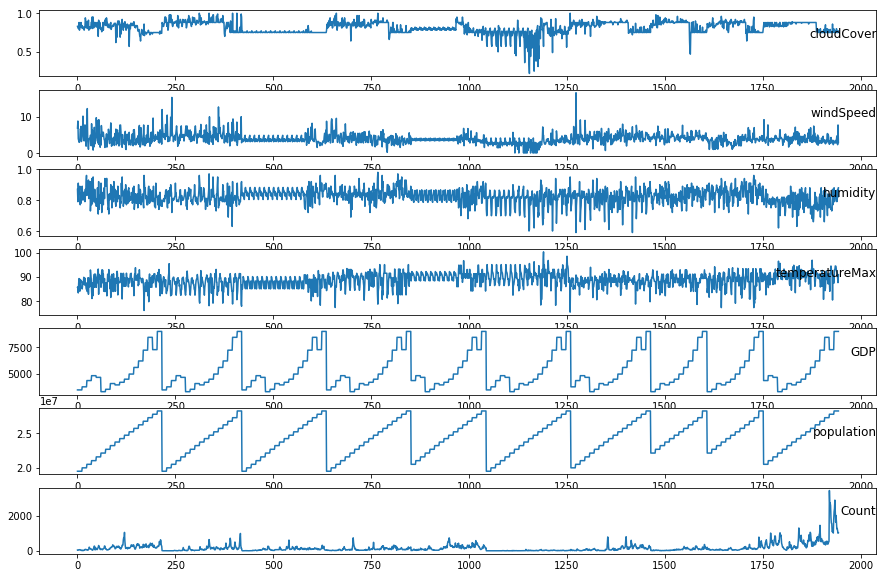

In [63]:
##Visualize continous features

values = mdf.values
groups = [3,4,5,6,7,8,9] ##specifying which columns to plot
i = 1

plt.figure(figsize=(15,10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(mdf.columns[group], y=0.5, loc='right')
    i += 1
plt.show()


## Time Series Analysis

#### First, I'd like to observe reported cases as a univariate time series.

In [64]:
df = mdf.copy()


In [65]:
dff = pd.read_csv('MY.38362002.csv')
dff.PeriodStartDate.unique() #check for NA values or gaps. 

array(['1993-01-01', '1993-02-01', '1993-03-01', '1993-04-01',
       '1993-05-01', '1993-06-01', '1993-07-01', '1993-08-01',
       '1993-09-01', '1993-10-01', '1993-11-01', '1993-12-01',
       '1994-01-01', '1994-02-01', '1994-03-01', '1994-04-01',
       '1994-05-01', '1994-06-01', '1994-07-01', '1994-08-01',
       '1994-09-01', '1994-10-01', '1994-11-01', '1994-12-01',
       '1995-01-01', '1995-02-01', '1995-03-01', '1995-04-01',
       '1995-05-01', '1995-06-01', '1995-07-01', '1995-08-01',
       '1995-09-01', '1995-10-01', '1995-11-01', '1995-12-01',
       '1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
       '1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
       '1996-09-01', '1996-10-01', '1996-11-01', '1996-12-01',
       '1997-01-01', '1997-02-01', '1997-03-01', '1997-04-01',
       '1997-05-01', '1997-06-01', '1997-07-01', '1997-08-01',
       '1997-09-01', '1997-10-01', '1997-11-01', '1997-12-01',
       '1998-01-01', '1998-02-01', '1998-03-01', '1998-

In [66]:
dff.PeriodStartDate = pd.to_datetime(dff['PeriodStartDate'])

In [67]:
df['time'] = dff.PeriodStartDate #bring back time, remove month and year and set time as the index
df.drop(['month', 'year'], inplace= True, axis = 1)



In [68]:
df.set_index('time', inplace = True)

## Since there are multiple observations per time stamp I'm only going to observe one city. For the sake of simplicty, I chose the first City presented in the set "JOHOR"

In [69]:
Jo = df[df.City == 'JOHOR']
Jo.info() # try running a time series with only one city

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 1993-01-01 to 2010-12-01
Data columns (total 8 columns):
City              216 non-null object
cloudCover        216 non-null float64
windSpeed         216 non-null float64
humidity          216 non-null float64
temperatureMax    216 non-null float64
GDP               216 non-null int64
population        216 non-null int64
Count             216 non-null int64
dtypes: float64(4), int64(3), object(1)
memory usage: 15.2+ KB


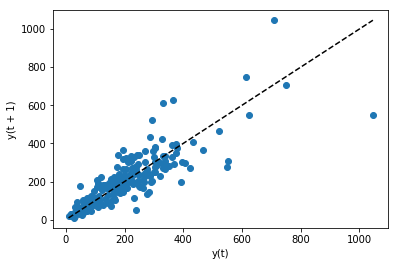

In [70]:

lag_plot(Jo['Count'])
plt.plot([Jo.Count.min(), Jo.Count.max()], [Jo.Count.min(), Jo.Count.max()], 'k--')
plt.show()

In [71]:
series = Jo.Count
values = pd.DataFrame(series.values)
dataf = pd.concat([values.shift(1), values], axis = 1)
dataf.columns = ['t-1', 't+1']
dataf.corr()

t-1       t+1
t-1  1.000000  0.836595
t+1  0.836595  1.000000

In [72]:

X = dataf.values
train, test = X[1:len(X)-108], X[len(X)-108:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]



Lag: 12
MSE:  35071.63565229575


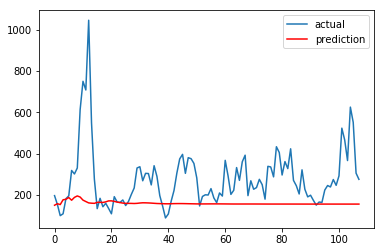

In [73]:

X = series.values
train, test = X[1:len(X)-108], X[len(X)-108:]
model = AR(train)

model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
error = mean_squared_error(test, predictions)
print('MSE: ', error)


# plot results
plt.plot(test, label = 'actual')
plt.plot(predictions, color='red', label = 'prediction')
plt.legend()
plt.show()

## Tree and ensemble methods

In [304]:
mse = [] ##make a list to append model Mean Squared Errors

In [305]:
## make dummy variables out of Cities, start trees and ensemble methods for regression :)

cityDummies = pd.get_dummies(mdf.City)
newdf = pd.concat([mdf, cityDummies], axis = 1)

In [306]:
newdf.head()

City  month  year  cloudCover  windSpeed  humidity  temperatureMax   GDP  \
0  JOHOR      1  1993    0.830000       6.91      0.87           85.70  3433   
1  JOHOR      2  1993    0.816250       8.87      0.79           85.86  3433   
2  JOHOR      3  1993    0.802143       3.96      0.91           83.35  3433   
3  JOHOR      4  1993    0.801333       3.42      0.84           87.52  3433   
4  JOHOR      5  1993    0.880000       2.99      0.86           89.31  3433   

   population  Count  JOHOR  KELANTAN  NEGERI SEMBILAN  PAHANG  PERAK  PERLIS  \
0    19484898     41      1         0                0       0      0       0   
1    19484898     52      1         0                0       0      0       0   
2    19484898     35      1         0                0       0      0       0   
3    19484898     45      1         0                0       0      0       0   
4    19484898     55      1         0                0       0      0       0   

   PULAU PINANG  SABAH  SARAWAK  SELANGOR  
0             0      0        0         0  
1             0      0        0         0  
2             0      0        0         0  
3             0      0        0         0  
4             0      0        0         0

In [307]:
newdf = newdf.drop( 'City', axis = 1)

In [308]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1944 entries, 0 to 1943
Data columns (total 19 columns):
month              1944 non-null int64
year               1944 non-null int64
cloudCover         1944 non-null float64
windSpeed          1944 non-null float64
humidity           1944 non-null float64
temperatureMax     1944 non-null float64
GDP                1944 non-null int64
population         1944 non-null int64
Count              1944 non-null int64
JOHOR              1944 non-null uint8
KELANTAN           1944 non-null uint8
NEGERI SEMBILAN    1944 non-null uint8
PAHANG             1944 non-null uint8
PERAK              1944 non-null uint8
PERLIS             1944 non-null uint8
PULAU PINANG       1944 non-null uint8
SABAH              1944 non-null uint8
SARAWAK            1944 non-null uint8
SELANGOR           1944 non-null uint8
dtypes: float64(4), int64(5), uint8(10)
memory usage: 250.9 KB


In [309]:
X = newdf.drop('Count', axis = 1)
y = newdf.Count

In [310]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 100)

In [311]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1555, 18), (389, 18), (1555,), (389,))

In [312]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [313]:
y_pred = model.predict(X_test)
m1 = mean_squared_error(y_test,y_pred)
print('MSE test: ',m1)
mse.append(m1)



MSE test:  15842.344473007712


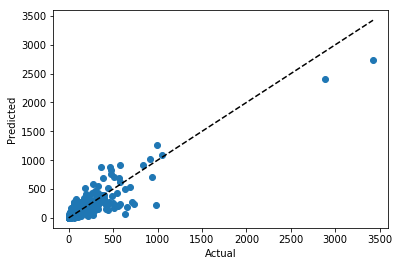

In [314]:

plt.show
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')


In [315]:
newnewdf = newdf[newdf.Count <= 800] # drop outliers for better performance?

In [316]:
newnewdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1900 entries, 0 to 1919
Data columns (total 19 columns):
month              1900 non-null int64
year               1900 non-null int64
cloudCover         1900 non-null float64
windSpeed          1900 non-null float64
humidity           1900 non-null float64
temperatureMax     1900 non-null float64
GDP                1900 non-null int64
population         1900 non-null int64
Count              1900 non-null int64
JOHOR              1900 non-null uint8
KELANTAN           1900 non-null uint8
NEGERI SEMBILAN    1900 non-null uint8
PAHANG             1900 non-null uint8
PERAK              1900 non-null uint8
PERLIS             1900 non-null uint8
PULAU PINANG       1900 non-null uint8
SABAH              1900 non-null uint8
SARAWAK            1900 non-null uint8
SELANGOR           1900 non-null uint8
dtypes: float64(4), int64(5), uint8(10)
memory usage: 167.0 KB


In [317]:
X = newnewdf.drop('Count', axis = 1)
y = newnewdf.Count

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 100)


In [319]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1520, 18), (380, 18), (1520,), (380,))

In [320]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [321]:
y_pred = model.predict(X_test)
m2 = mean_squared_error(y_test,y_pred)
print('MSE: ', m2)
mse.append(m2)



MSE:  14513.121052631579


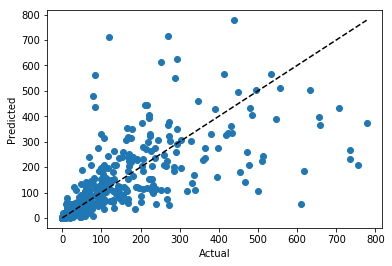

In [322]:

plt.show
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')


In [323]:

param_grid = {
    'splitter': ['random', 'best'],
    'max_features': [2,4,6,8,10,12],
    'max_leaf_nodes': [None, 2, 4, 6, 8, 10],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6],
    
    
}

In [324]:
%%time
gs_tree = GridSearchCV(model, param_grid, cv = 3)
gs_tree.fit(X_train, y_train)
print('The best paramaters are ', gs_tree.best_params_)

The best paramaters are  {'max_depth': None, 'max_features': 8, 'max_leaf_nodes': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'random'}
CPU times: user 2min 54s, sys: 2.67 s, total: 2min 57s
Wall time: 3min 4s


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


MSE:  10134.34130229094


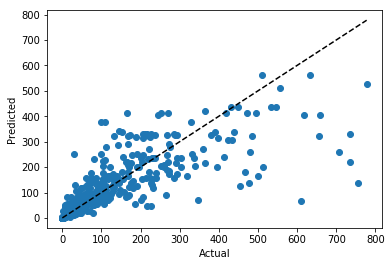

In [325]:
tree2 = DecisionTreeRegressor(max_depth= None, max_features=10, max_leaf_nodes=None, min_samples_leaf= 4, min_samples_split=5, splitter= 'random')
                             
tree2.fit(X_train,y_train)
tree2predictions = tree2.predict(X_test)
m3 = mean_squared_error(y_test,tree2predictions)
print('MSE: ',m3)
mse.append(m3)
plt.show
plt.scatter(y_test,tree2predictions)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')

In [326]:

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [327]:
predictions = rf.predict(X_test)
m4 = mean_squared_error(y_test,predictions)
print('MSE: ',m4)
mse.append(m4)



MSE:  8373.593657894737


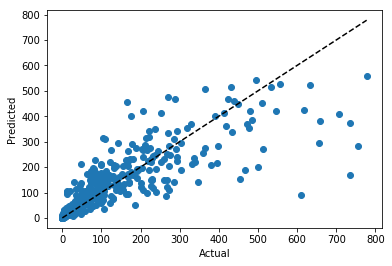

In [328]:

plt.show
plt.scatter(y_test,predictions)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')


In [329]:
param_grid = {
    'bootstrap' : [True, False],
    'max_features': [2,4,12],
    'max_depth': [None, 2,  4],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3 ],
    'n_jobs': [None, 2, 4]
    
    
}

In [330]:
%%time
gs_tree2 = GridSearchCV(rf, param_grid, cv = 3)
gs_tree2.fit(X_train, y_train)
print('The best paramaters are ', gs_tree2.best_params_)

The best paramaters are  {'bootstrap': False, 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_jobs': 2}
CPU times: user 1min 7s, sys: 12 s, total: 1min 19s
Wall time: 7min 57s


In [331]:

rf2= RandomForestRegressor(bootstrap=False, max_depth= None, max_features=12, min_samples_leaf=2, min_samples_split=5, n_jobs=None)
rf2.fit(X_train, y_train)
preds = rf2.predict(X_test)
m5 = mean_squared_error(y_test,preds)
print('MSE: ',m5)
mse.append(m5)

MSE:  8471.019124634502


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


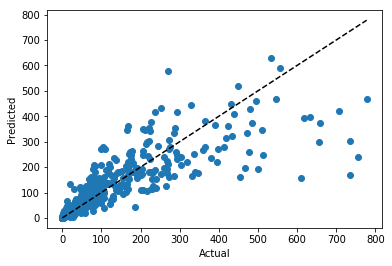

In [332]:

plt.show
plt.scatter(y_test,preds)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')


In [333]:

x_gb = xgb.XGBRegressor()
x_gb.fit(X_train,y_train)
x_gbpred = x_gb.predict(X_test)
m6 =  mean_squared_error(y_test,x_gbpred)
print('MSE: ', m6)
mse.append(m6)

MSE:  9539.198800552445


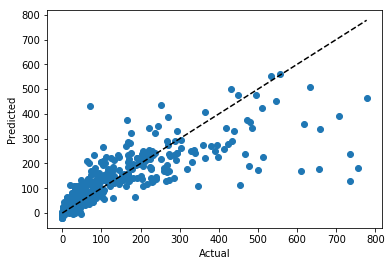

In [334]:

plt.show
plt.scatter(y_test,x_gbpred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')


In [335]:

param_grid = {
    "learning_rate": [0.1, 0.8, 0.10],
    'max_depth': [5, 10, 15],
    'min_child_weight': [10, 15],
    'subsample': [0.2, 0.5, 0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [336]:
%%time
gs_tree3 = GridSearchCV(x_gb, param_grid, cv = 3)
gs_tree3.fit(X_train, y_train)
print('The best paramaters are ', gs_tree3.best_params_)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best paramaters are  {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 15, 'n_estimators': 100, 'subsample': 0.7}
CPU times: user 2min 25s, sys: 951 ms, total: 2min 26s
Wall time: 2min 28s


In [337]:

x_gb2 = xgb.XGBRegressor(learning_rate=.1 , max_depth=5, min_child_weight=15,n_estimators=100, subsample=.7)
x_gb2.fit(X_train,y_train)
x_gbpred2 = x_gb2.predict(X_test)
m7 = mean_squared_error(y_test,x_gbpred2)
print('MSE: ', m7)
mse.append(m7)



MSE:  9430.438835879859


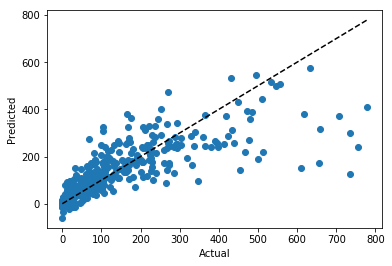

In [338]:
plt.show
plt.scatter(y_test,x_gbpred2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')

<BarContainer object of 7 artists>

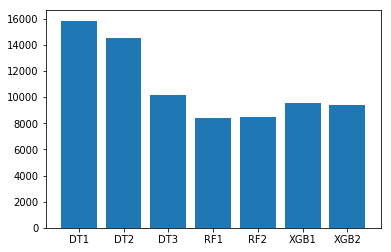

In [339]:

labels = ['DT1', 'DT2', 'DT3', 'RF1', 'RF2', 'XGB1', 'XGB2']
plt.bar(labels, mse)

In [340]:
m4, m5

(8373.593657894737, 8471.019124634502)

In [341]:

def plot_feature_importances(model, data_train):
    n_features = data_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

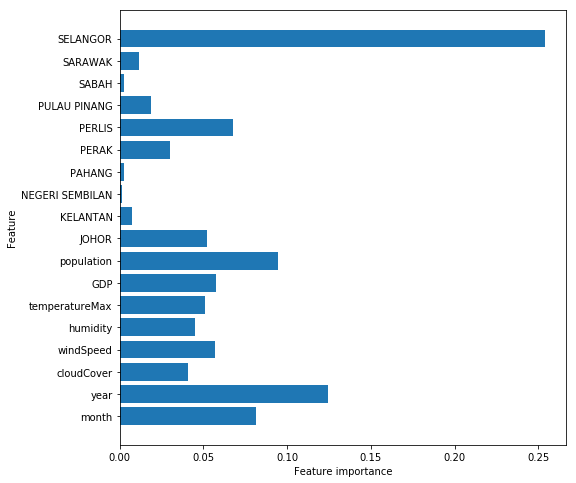

In [342]:
plot_feature_importances(rf, X_train)

In [343]:
X_train.head()

month  year  cloudCover  windSpeed  humidity  temperatureMax   GDP  \
728       9  2000    0.846667      3.996  0.848571       89.134667  4043   
1879      8  2005    0.880000      3.100  0.660000       93.280000  5587   
1641     10  2000    0.900000      3.310  0.890000       84.460000  4043   
452       9  1995    0.758000      4.910  0.874000       85.460000  4329   
118      11  2002    0.870000      3.630  0.780000       91.120000  4165   

      population  JOHOR  KELANTAN  NEGERI SEMBILAN  PAHANG  PERAK  PERLIS  \
728     23194257      0         0                0       1      0       0   
1879    25690611      0         0                0       0      0       0   
1641    23194257      0         0                0       0      0       0   
452     20487607      0         0                1       0      0       0   
118     24208391      1         0                0       0      0       0   

      PULAU PINANG  SABAH  SARAWAK  SELANGOR  
728              0      0        0         0  
1879             0      0        0         1  
1641             0      0        1         0  
452              0      0        0         0  
118              0      0        0         0

In [354]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   mode = 'regression',
                                                   feature_names = X_train.columns,
                                                   categorical_features = [8,9,10,11,12,13,14,15,16,17], 
                                                   categorical_names = ['JOHOR', 'KELANTAN', 'NEGERI SEMBILAN', 'PAHANG', 'PERAK', 'PERLIS',
       'PULAU PINANG', 'SABAH', 'SARAWAK', 'SELANGOR'], 
                                                   discretize_continuous = True)
exp = explainer.explain_instance(X_test.values[31], rf.predict, num_features = 10)
exp.show_in_notebook(show_all=False) #only the features used in the explanation are displayed

exp = explainer.explain_instance(X_test.values[85], rf.predict, num_features = 10)
exp.show_in_notebook(show_all=False)

exp = explainer.explain_instance(X_test.values[66], rf.predict, num_features = 10)
exp.show_in_notebook(show_all=False) #only the features used in the explanation are displayed

exp = explainer.explain_instance(X_test.values[33], rf.predict, num_features = 10)
exp.show_in_notebook(show_all=False)

In [351]:
y_test.values[31] , y_test.values[85], y_test.values[66], y_test.values[33]

(226, 191, 98, 142)

### soooo....not the most accurate predictions, but here's what my best performing models tell me

#### Contrary to my beliefs, weather didn't play a huge role in predicting count. Rather, location seems to be the big deciding factor. Specifically in the cities of Selangor, Johor, and Perak which, if you're residing in any of these cities, your likelihood of contracting Dengue seems to increase.

#### Conversely, 'not living' in Perlis seemed to cause increased cases of Dengue fever. Perhaps Perlis is a relatively safer city to be in when it comes to Dengue

#### Population also played a large role in predictions, although this feature is a bit controversial. The population reported on this dataset is that of the entire country and not of the cities. That being said, populations over 2,420,839 is linked to higher instances of the disease

#### Another noteworthy feature is year, observations made after 2002 allegedly linked to higher instances of Dengue


#### There's a lot more that can be done to achieve more accuracy with this dataset. To improve my results, I would try a bit harder to find city specific population counts, test out more models, and try to see if I can find any city/time specific precipitation data. Darksky did not report on rain for any of these cities which I found to be a huge setback. As a former resident of Southeast Asia (Bangladesh), I can assure you that mosquitos thrive in damp conditions. More mosquitos = more dengue....Right? 

### to be continued...